In [44]:
import os
!pip install torchcam
!pip install onnx
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import zipfile
from torchvision.transforms.functional import to_pil_image
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
import gradio as gr


In [43]:
# =============================
# Device Setup
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [47]:
# --- Dataset Extraction ---
zip_path = "/content/drive/MyDrive/E-Waste classification dataset.zip"
extract_path = "/content/E-Waste classification dataset"

# Ensure the directory exists
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [81]:
# =============================
# Paths (update these)
# =============================
train_dir = "/content/E-Waste classification dataset/modified-dataset/train"
val_dir = "/content/E-Waste classification dataset/modified-dataset/val"
test_dir = "/content/E-Waste classification dataset/modified-dataset/test"

In [82]:
# Datasets and Loaders
train_dataset = datasets.ImageFolder(train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(val_dir, transform=transform_eval)
test_dataset = datasets.ImageFolder(test_dir, transform=transform_eval)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [83]:
num_classes = len(train_dataset.classes)
num_classes

10

In [51]:
class_names = train_dataset.classes
class_names

['Battery',
 'Keyboard',
 'Microwave',
 'Mobile',
 'Mouse',
 'PCB',
 'Player',
 'Printer',
 'Television',
 'Washing Machine']

In [52]:
# Load Pretrained MobileNetV3
model = models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)
model = model.to(device)



In [53]:
# Loss, Optimizer, Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)

In [54]:
# Training Function
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()

    print(f"Best Validation Accuracy: {best_acc:.4f}")
    model.load_state_dict(best_model_wts)
    return model

In [55]:
# Train the Model
model = train_model(model, criterion, optimizer, scheduler)

Epoch 1/15
train Loss: 0.8611 Acc: 0.7146
val Loss: 0.9196 Acc: 0.7500
Epoch 2/15
train Loss: 0.3382 Acc: 0.8833
val Loss: 0.3306 Acc: 0.8833
Epoch 3/15
train Loss: 0.2540 Acc: 0.9250
val Loss: 0.3306 Acc: 0.9067
Epoch 4/15
train Loss: 0.1493 Acc: 0.9508
val Loss: 0.2822 Acc: 0.9100
Epoch 5/15
train Loss: 0.1374 Acc: 0.9563
val Loss: 0.4273 Acc: 0.8700
Epoch 6/15
train Loss: 0.1387 Acc: 0.9546
val Loss: 0.3350 Acc: 0.9167
Epoch 7/15
train Loss: 0.1468 Acc: 0.9554
val Loss: 0.3932 Acc: 0.8833
Epoch 8/15
train Loss: 0.0792 Acc: 0.9712
val Loss: 0.2496 Acc: 0.9333
Epoch 9/15
train Loss: 0.0341 Acc: 0.9867
val Loss: 0.2322 Acc: 0.9300
Epoch 10/15
train Loss: 0.0256 Acc: 0.9929
val Loss: 0.2553 Acc: 0.9367
Epoch 11/15
train Loss: 0.0297 Acc: 0.9938
val Loss: 0.2786 Acc: 0.9200
Epoch 12/15
train Loss: 0.0279 Acc: 0.9921
val Loss: 0.2920 Acc: 0.9300
Epoch 13/15
train Loss: 0.0221 Acc: 0.9950
val Loss: 0.2895 Acc: 0.9200
Epoch 14/15
train Loss: 0.0085 Acc: 0.9975
val Loss: 0.2853 Acc: 0.9267
E

In [69]:
# Confusion Matrix & Report
def evaluate_detailed(model, loader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Greens")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()




Classification Report:

                 precision    recall  f1-score   support

        Battery       0.85      0.77      0.81        30
       Keyboard       0.97      1.00      0.98        30
      Microwave       0.83      1.00      0.91        30
         Mobile       0.90      0.90      0.90        30
          Mouse       0.83      0.97      0.89        30
            PCB       0.90      0.93      0.92        30
         Player       0.96      0.80      0.87        30
        Printer       0.93      0.87      0.90        30
     Television       0.93      0.83      0.88        30
Washing Machine       0.97      0.97      0.97        30

       accuracy                           0.90       300
      macro avg       0.91      0.90      0.90       300
   weighted avg       0.91      0.90      0.90       300



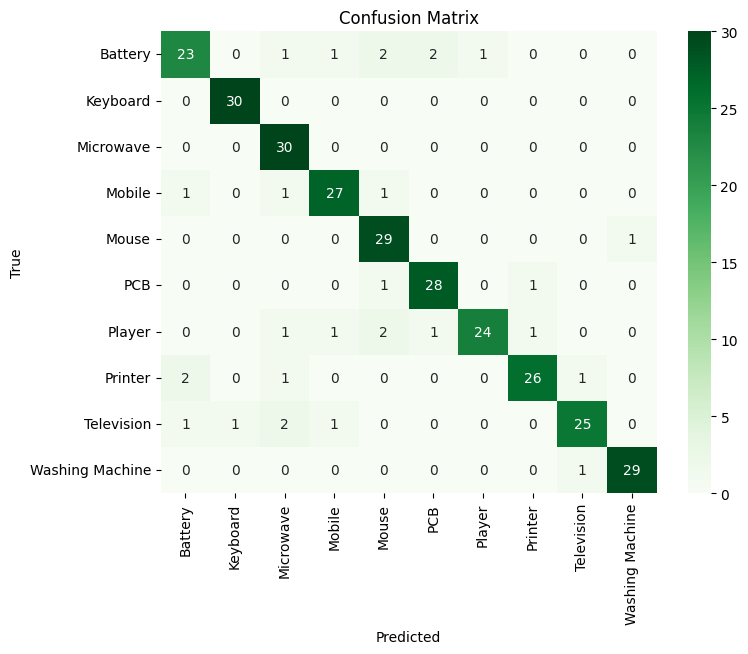

In [70]:
evaluate_detailed(model, test_loader, class_names)

In [72]:
# Grad-CAM Visualization
cam_extractor = GradCAM(model, target_layer="features.12")
image_tensor, label = test_dataset[0]
input_tensor = image_tensor.unsqueeze(0).to(device)



In [73]:
model.eval()

# ✅ Ensure gradients are enabled
output = model(input_tensor)  # Don't use torch.no_grad()
pred_class = output.argmax(dim=1).item()

# ✅ Generate Grad-CAM (requires gradient tracking)
activation_map = cam_extractor(pred_class, output)

# ✅ Visualize CAM over the image
result = overlay_mask(to_pil_image(image_tensor),
                      to_pil_image(activation_map[0].squeeze(0), mode='F'),
                      alpha=0.5)
result.show()


In [74]:
# Clean up GradCAM extractor if it exists
try:
    cam_extractor.remove_hooks()  # Cleanly removes registered hooks
    del cam_extractor
except NameError:
    pass  # cam_extractor doesn't exist, safe to continue


In [75]:
# Re-initialize a clean version of the model (no Grad-CAM, no hooks)
model_clean = models.mobilenet_v3_small(pretrained=True)
model_clean.classifier[3] = nn.Linear(model_clean.classifier[3].in_features, num_classes)
model_clean.load_state_dict(model.state_dict())  # copy trained weights
model_clean = model_clean.to(device)
model_clean.eval()

# Export clean model to TorchScript
dummy_input = torch.randn(1, 3, 128, 128).to(device)
scripted_model = torch.jit.trace(model_clean, dummy_input)
scripted_model.save("ewaste_model.pt")
print("✅ Saved TorchScript model as ewaste_model.pt (clean)")


✅ Saved TorchScript model as ewaste_model.pt (clean)


In [39]:
from google.colab import files
files.download("ewaste_model.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## ✅ E-Waste Classification Deployment

The model is deployed using Gradio and TorchScript on Hugging Face.

👉 [Click to open the app](https://huggingface.co/spaces/Nuthi-Pragna/e-waste_classification)


In [77]:
#or use the link in this cell to open the app
from IPython.display import display, HTML

display(HTML('''
    <a href="https://huggingface.co/spaces/Nuthi-Pragna/e-waste_classification" target="_blank">
        <button style="font-size:16px;padding:10px 20px;color:white;background-color:#28a745;border:none;border-radius:5px;">
            🚀 Open E-Waste Classifier App
        </button>
    </a>
'''))
